# Feature Engineering 

## - Objectives - 
### 1 - Scale cumulative season long stats to be able to compare players.

#### 1.1 - Convert player season data to per 90 stats to adjust for different amounts of games played per player.

#### 1.2 - Create possesion adjusted stats for defensive KPIs to better represent defenders stat accurance.

#### 1.3 - Clean up positional feature to be used to filter data set

### 2 - Engineer specfic defensive features from p90 and pAdj scaled features to allow for better comparisons between defenders. 

In [1]:
# make necessary imports 
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
## load data and remove unneeded columns 
path = "../data/all_salary_stats.csv"
df= pd.read_csv(path)
df.drop(columns=['Position(s)','Unnamed: 0','Unnamed: 0.1','First Name', 'Last Name', 'name', '_merge','Guaranteed Compensation'],inplace=True)
df.shape

(705, 103)

In [3]:
# observe target player inital features 
df[df['player_name']=='Walker Zimmerman'][['player_name','Nineties','Total_tackles','Blocks','Tackles_Won','Key_pass','Total_Cmp','Total_Att']]


,player_name,Nineties,Total_tackles,Blocks,Tackles_Won,Key_pass,Total_Cmp,Total_Att
376,Walker Zimmerman,22.7,27,29,15,5,855,1016


## 1- Scale cumulative season long stats to be able to compare players.
### 1.1 - Adjust season stats to per ninety stats for accurate stat comparison.

In [4]:
## create list of columns to be adjusted to per 90 stats
cols =  [
    # def stats
    'Total_tackles', 'Tackles_Won', 'Tackles_Def_3rd',
       'Tackles_Mid_3rd', 'Tackles_Att_3rd', 'Num_Dribblers_tackled',
       'Num_Dribbled_past', 'total_pressing', 'Won_ball_5_sec', 
       # 'Tackle_pct_won',- pct not scaled 
    'pres_Def_3rd', 'pres_Mid_3rd', 'pres_Att_3rd',
       'Blocks', 'Blocked_shots', 'Blocked_SOT', 'Blocked_pass',
       'Interceptions', 'Tackles_and_Ints', 'Clearences',
    # passing stats
'xA','Key_pass','Comp_prog','Total_Cmp','Total_Att','Total_Tot_Dist','Total_Prg_Dist','Short_Cmp','Short_Att','Medium_Cmp','Medium_Att','Long_Cmp','Long_Att',
'touches','touches_def_box','touches_def_3rd','touches_mid_3rd','touches_att_3rd','touches_att_box','touch_live',
    # attacking stats
    'dribble_Succ','dribble_Att','num_dribble_past','dribble_megs','carries','carries_dist','carries_prog_dist','carries_prog','carries_att_3rd','carries_att_box','miss_control','dispossed','recep_targ',
'recep_succ','Yellow_cards','Red_cards','Second_yellow','Fouls','Fouls_drawn','Offsides','Crosses','def_interceptions',
    # mish stats 
    'from_mish_tackles_won','PK_won','PK_conceded','OG',
'Recoveries','Aerial_Duels_lost','Gls','Sh','SoT','Sh/90','SoT/90','G/Sh','G/SoT','Dist','FK','PK','PKatt', 'xG','npxG','npxG/Sh','G-xG','np:G-xG'
]

In [5]:
def per_90(cols,df):
    # create list of games played values and map anything less than 1 to one 
    games=[i if i >1 else 1 for i in df['Nineties'] ]
    # use new list to do calc so not dividing by value less than 1 
    for col in cols:
        df[col] = df[col]/games
    return df

df =  per_90(cols,df)
df[df['player_name']=='Walker Zimmerman'][['player_name','Nineties','Total_tackles','Total_tackles','Tackles_Won','Key_pass','Total_Cmp','Total_Att']]


,player_name,Nineties,Total_tackles,Total_tackles,Tackles_Won,Key_pass,Total_Cmp,Total_Att
376,Walker Zimmerman,22.7,1.189427,1.189427,0.660793,0.220264,37.665198,44.757709


In [6]:
## check players who played less than 1 game no not have increased features
df.loc[(df['Nineties']==0.1) | (df['player_name']=='Jordan Harvey') ][['player_name', 'Squad_from_op','Long_Att','Long_Cmp','Long_Cmp_pct', 'Nation', 'Position', 'Nineties','xA', 'Key_pass']].head(1)

,player_name,Squad_from_op,Long_Att,Long_Cmp,Long_Cmp_pct,Nation,Position,Nineties,xA,Key_pass
605,Jason Pendant,NY Red Bulls,4.0,3.0,75.0,fr FRA,DF,0.1,0.0,0.0


## 1.2 - Create possesion adjusted metrics ie " pAdj " to better represent defenders stat accurance.

- using per 1000 opponent touches as scale to create pAdj stat 
- ex: tackles per 1000 opponent touches instead of just tackles per 90 

In [7]:
   # defensive stats to be adjusted by possesion 
    
def_cols=[
        'Total_tackles', 'Tackles_Won', 'Tackles_Def_3rd',
       'Tackles_Mid_3rd', 'Tackles_Att_3rd', 'Num_Dribblers_tackled',
       'Num_Dribbled_past', 'total_pressing', 'Won_ball_5_sec',
       #'Tackle_pct_won', - pct not adjusted
    'pres_Def_3rd', 'pres_Mid_3rd', 'pres_Att_3rd',
       'Blocks', 'Blocked_shots', 'Blocked_SOT', 'Blocked_pass',
       'Interceptions', 'Tackles_and_Ints', 'Clearences',
    
      # defensive stats to be adjusted by possesion 
    'Yellow_cards','Red_cards','Second_yellow','Fouls','def_interceptions',
    'from_mish_tackles_won','PK_conceded','OG','Recoveries','Aerial_Duels_lost']

In [8]:
def pAdj(df,cols):
  """ create possesion adjusted defensive stats and remove orignial"""
  for col in cols:
    label = 'pAdj_'+col
    # each team played 34 games so to get opposing touches per 90 divide by 34
    df[label] = (df[col]/(df['Opposing_Touches']/34)) * 1000
    df.drop(columns=[col],inplace=True)
  
  return df

df=pAdj(df,def_cols)
df['Opposing_Touches'].describe()
df[df['player_name']=='Walker Zimmerman'][[ 'player_name','pAdj_def_interceptions','pAdj_from_mish_tackles_won', 'pAdj_Total_tackles', 'pAdj_Tackles_Won','pAdj_Recoveries','pAdj_Aerial_Duels_lost']].head()



,player_name,pAdj_def_interceptions,pAdj_from_mish_tackles_won,pAdj_Total_tackles,pAdj_Tackles_Won,pAdj_Recoveries,pAdj_Aerial_Duels_lost
376,Walker Zimmerman,3.477266,1.04318,1.877723,1.04318,12.448611,7.789075


In [9]:
## observe players with highest defensive interceptions
print(max(df['pAdj_def_interceptions']))
df.loc[df['pAdj_def_interceptions']>8][['player_name','pAdj_def_interceptions', 'pAdj_Tackles_Won','Key_pass', 'Squad_from_op','Nineties']]

8.50255076522957


,player_name,pAdj_def_interceptions,pAdj_Tackles_Won,Key_pass,Squad_from_op,Nineties
455,Nathan Cardoso,8.359709,6.174785,0.15625,San Jose,19.2
613,Alejandro Fuenmayor,8.015465,0.534364,0.00000,Houston Dynamo,3.0
691,Youba Diarra,8.502551,3.643950,0.00000,NY Red Bulls,1.4


### 1.3 - Clean up positional feature to be used to filter data set

In [10]:
## deal with positional abiguity in raw data and map to three field positions 

for i in df['Position'].unique():
  if i in ['FWMF','MFFW','MFDF','DFMF']:
    df['Position'] = df['Position'].str.replace(i,'MF')

  if i in ['FWDF', 'DFFW']:
    df['Position'] = df['Position'].str.replace(i,'FW')




## 2- Engineer specfic defensive features from p90 and pAdj scaled features to allow for better comparisons between defenders. 

### 2.1 True Tackle Win percent feature generation. 

### 2.2 create descriptive defender specific features that will be used in modeling.

## 2.1 Create true tackle win pct feature to beter measure player tackle percentage 
 - Usual tackl win % is measured by - tackl won/ (tackle won +tackle lost)
 
 - The Athletic(https://theathletic.com/author/tifo-football/) calculates True tackle win % to better represent players defensive actions. Their equation is (total tackles / total tackles +challanges lost + fouls when attempting a tackle)
 
 - With the fb_ref features my true tackle win % will be calculated by  (total tackles / total tackles + lost tackles+ number dribbled past +fouls)

0


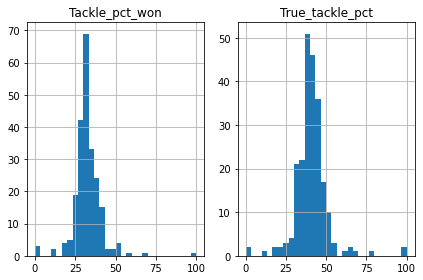

In [11]:
df['lost_tackles'] = df['pAdj_Total_tackles'] - df['pAdj_Tackles_Won']

# calculation for true tackle
df['True_tackle_pct'] = (df['pAdj_Total_tackles']/(df['pAdj_Total_tackles']+df['lost_tackles']+
                                                   df['pAdj_Num_Dribbled_past']+df['pAdj_Fouls']) *100)

# deal with edge cases that dont give percent keep original tackle pct
df.loc[df['True_tackle_pct'].isnull(),'True_tackle_pct'] = df['Tackle_pct_won']
df.loc[df['True_tackle_pct']==0,'True_tackle_pct'] = df['Tackle_pct_won']
# check if all edge cases delt with
print(df['True_tackle_pct'].isnull().sum())
#check distribution of new feature
df.loc[df['Position']=='DF'][['Tackle_pct_won','True_tackle_pct']].hist(bins=30)
plt.tight_layout()
plt.show()

### Insight-  True tackle pct for defenders has moved the median and the mode towards the right while also creating a wider curve than the original tackle pct. 

### 2.2 Create descriptive defender specific features that will be used in modeling.

In [12]:
## create tackle int blocks from pAdj stats  
df['pAdj_Tackle_int_blocks'] = df['pAdj_Tackles_Won']+df['pAdj_def_interceptions']+df['pAdj_Blocks']

# consolidate short and medium passing percentage
df['avg_shrt+med_pass_pct'] = (df['Short_Cmp_pct']+df['Medium_Cmp_pct'])/2

## get ratio of long balls for players to have a feel about who passes at distance the most 
df['pct_long_balls']=(df['Long_Att']/df['Total_Att']) *100

## who effecivly moves the ball up the field on the dribble or through the air 
df['prog_carry+lng_comp+crosses'] = df['carries_prog']+df['Long_Cmp']+df['Crosses']

# put all of the attack minded touch features into one 
df['attacking_touches']= df['touches_att_3rd']+df['touches_att_box']+ df['num_dribble_past'] +df['carries_att_3rd']+df['carries_att_box']


df.loc[(df['Position']=='DF')][['pAdj_Tackle_int_blocks','avg_shrt+med_pass_pct','pct_long_balls','prog_carry+lng_comp+crosses','attacking_touches']].describe()

,pAdj_Tackle_int_blocks,avg_shrt+med_pass_pct,pct_long_balls,prog_carry+lng_comp+crosses,attacking_touches
count,227.000000,227.000000,227.000000,227.000000,227.000000
mean,8.023239,88.849559,20.075834,10.324587,12.870451
std,2.648393,4.687214,6.946924,3.302164,9.953301
min,0.000000,66.300000,4.864865,1.000000,0.000000
25%,6.858791,85.975000,14.534469,8.133214,3.910742
50%,7.844741,89.200000,19.695757,10.598291,9.190283
75%,9.558449,92.500000,25.083286,12.593765,21.456015
max,21.104904,100.000000,43.854749,22.636364,38.461538


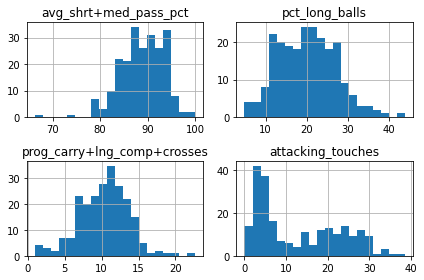

In [14]:
df.loc[(df['Position']=='DF')][['avg_shrt+med_pass_pct','pct_long_balls','prog_carry+lng_comp+crosses','attacking_touches']].hist(bins=20)
plt.tight_layout()
plt.show()

In [15]:
# save df with adjusted features for further steps

df.to_csv('../data/final_per_90_and_pAdj.csv', encoding='utf-8', index=False)

